<a href="https://colab.research.google.com/github/AnirudhMoolya/Lecture-notes/blob/main/Exercise%2011%20-%20Data%20fitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Anirudh Moolya
<br>
Date: Feb. 4, 2022
<br>
PHYS 2030 W22

# <center><font color=#46769B>Exercise 11: Data fitting</font></center>

## <font color=#46769B>Introduction</font>

Let's say you have some observed data and a mathematical model that you would like to use to fit the data. The model depends on a parameter, say, $x$. You would like to know what the data tells you about $x$. 

Monte Carlo sampling is a general method to handle this type of problem, known as an __inverse problem__. In a "non-inverse" problem, we might have a PDF for $x$, $P(x)$, which we then use to calculate an observable. Here, we are going in the opposite direction: using the observables (measured by observations) to determine the PDF for $x$.

To be more quantitative, here is the setup.
Let $v_1$, $v_2$, $v_3$, etc. denote observables that have been measured. Their means and uncertainties are denoted by $\mu_k$ and $\sigma_k$, so we would quote the measurements as
$$v_1 = \mu_1 \pm \sigma_1 , \quad v_2 = \mu_2 \pm \sigma_2, \quad v_3 = \mu_3 \pm \sigma_3 , \, ... $$ 
We have a mathematical model that will allow us to calculate each of these quantities in terms of a parameter $x$:
$$v_1 = f_1(x) , \quad v_2 = f_2(x) , \quad v_3 = f_3(x), \, ...$$
We need a way to calculate how well the model and data agree. We will calculate the chi-squared:
$$\chi^2(x) = \frac{(f_1(x) -\mu_1)^2}{\sigma_1^2} + \frac{(f_2(x) - \mu_2)^2}{\sigma_2^2} + ... 
= \sum_{k=1}^n \frac{(f_k(x) - \mu_k)^2}{\sigma_k^2}$$
where we have $n$ data points, labeled by index $k$.
We write $\chi^2(x)$ to make it clear that although we are summing over a list of data points, this quantity is just a function of the parameter $x$. The PDF for $x$ is related to the $\chi^2$ by
$$P(x) \propto e^{-\frac{1}{2}\chi^2(x)} \, .$$
There is an overall constant of proportionality that can (in principle) be determined by the normalization condition, $\int_{-\infty}^{\infty} dx \, P(x) = 1$.

Now that we have fixed $P(x)$, we can use importance sampling to estimate the mean value of $x$ and the standard deviation, i.e., $\mu_x$ and $\sigma_x$, respectively.

Our goals for this notebook are:
- Use importance sampling to fit parameters from data.

Required reading:
- *Lesson 5: Multivariate distributions*



## <font color=#46769B>Background</font>

In this Exercise, we will consider astrophysical data obtained by radio-wave observations of a nearby dwarf galaxy, DDO154, by [The HI Near Galaxy Survey (THINGS)](https://www2.mpia-hd.mpg.de/THINGS/Overview.html).
By fitting to this data, we will show that the galaxy is mostly made up of dark matter, which cannot be seen directly but is inferred through its gravitational pull.

First, let's describe the physics. In spiral galaxies, stars and gas move in circular orbits around the center of the galaxy. The centripetal force that holds them in a circular orbit is simply the force of gravity.

<div>
<img src="https://github.com/PHYS-2030-Computational-Methods/Lecture-notes/raw/main/figures/rotation.png" width="400">
<i>Figure credit (background): European Southern Observatory</i>
</div>

Suppose we have a star of mass $m_\star$, located at a radius $r$, moving with circular velocity $v$.
Its centripetal force is $F_{\rm cent} = \frac{m_\star v^2}{r}$. Its gravitational force is $F_{\rm grav} = \frac{G_N m_\star M}{r^2}$, where $G_N$ is Newton's gravitational constant and $M$ is the mass that exerts a gravitational pull on the star.
Setting the centripetal force equal to the gravitational force, we have the following relation for $v$:
$$v = \sqrt{\frac{G_N M(r)}{r}} \, . \qquad (1)$$

### <font color=#46769B>Enclosed mass function $M(r)$</font>

Note we have written $M(r)$. Let's clarify what this means.
Recall [Newton proved that](https://en.wikipedia.org/wiki/Shell_theorem) a traveler approaching the center of the Earth will feel less and less the effect of gravity until they become weightless at the center.
Similarly, if the distribution of mass is spherically symmetric in a galaxy, a star at larger radius will feel the gravitational pull from more of the mass compared to a star at a smaller radius.
For a star at radius $r$, it feels the pull of all mass interior to $r$ (i.e., within a sphere of radius $r$).

We will adopt the following function for the enclosed mass
$$M(r) = \frac{M_{\rm tot} r^3}{(r + a)^3} \, .$$
It is a function of radius $r$ and two parameters: 
- $M_{\rm tot}$ is the total mass of the galaxy, in units of solar masses $M_{\odot}$. That is, $M(r) \to M_{\rm tot}$ in the limit $r \to \infty$. Note $M_{\rm tot}$ includes all forms of matter that gravitate, not just the visible stars and gas that can be seen directly.
- $a$ is a length parameter, in units of kiloparsecs (kpc). $a$ represents a characteristic size of the galaxy.

When sampling, it is sometimes useful to work in the logarithm of a variable, instead of the variable itself.
Let's define
$$x = \log_{10}(a/{\rm kpc}) \, , \qquad y = \log_{10}(M_{\rm tot}/{\rm kpc}) $$
or equivalently
$$a = 10^x \; {\rm kpc} , \quad M_{\rm tot} = 10^y \; M_\odot \, .$$
Finally, $x$ and $y$ will be the variables that we will sample to determine $M_{\rm tot}$ and $a$.

### <font color=#46769B>Rotation curve data</font>

Here is a picture of the galaxy we will consider, DDO 154. 

<div>
<img src="https://github.com/PHYS-2030-Computational-Methods/Lecture-notes/raw/main/figures/ddo154_color.jpg" width="300">
<i>Figure credit: National Radio Astronomy Observatory</i>
</div>

Telescopes have measured the radio waves from the galaxy's hydrogen gas, which is emitted at a characteristic wavelength of $\lambda = 21$ cm in hyperfine transitions. 
The circular velocity is inferred by how the radio waves are redshifted or blueshifted away from this wavelength due to the relativistic Doppler effect.

In the cell below, we provide the data:
- `radius` is the list of $r$ values at which the rotation curve is measured (in kpc).
- `mu` is the list of mean values of the circular velocities measured at each radius (in km/s).
- `sigma` is the list of uncertainties on the circular velocity, at each radius (in km/s).

We plot the data, which is known as a *rotation curve*, using `matplotlib.pyplot.errorbar` to make a plot with error bars.

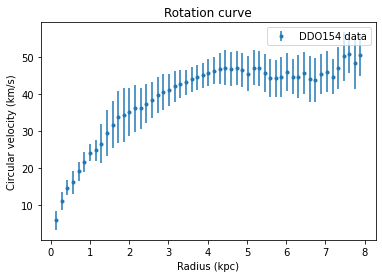

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Data

# radius (kpc) 
radius = np.array([0.14, 0.29, 0.43, 0.57, 0.72, 0.86, 1.  , 1.15, 1.29, 1.44, 1.58,
                   1.72, 1.87, 2.01, 2.15, 2.3 , 2.44, 2.58, 2.73, 2.87, 3.01, 3.16,
                   3.3 , 3.44, 3.59, 3.73, 3.87, 4.02, 4.16, 4.31, 4.45, 4.59, 4.74,
                   4.88, 5.02, 5.17, 5.31, 5.45, 5.6 , 5.74, 5.88, 6.03, 6.17, 6.31,
                   6.46, 6.6 , 6.74, 6.89, 7.03, 7.18, 7.32, 7.46, 7.61, 7.75, 7.89])

# mean circular velocity v (km/s) 
mu = np.array([  5.77, 10.98, 14.65, 16.02, 19.01, 21.58, 24.06, 24.68, 26.55,
                29.44, 31.67, 33.67, 34.35, 35.06, 36.08, 36.16, 37.32, 38.39,
                39.8 , 40.48, 41.13, 42.01, 42.8 , 43.19, 43.91, 44.44, 45.02,
                45.79, 46.22, 46.81, 47.13, 46.73, 46.98, 46.54, 45.47, 47.11,
                46.96, 45.65, 44.21, 44.21, 44.63, 45.9 , 44.66, 44.7 , 45.64,
                44.01, 43.69, 45.49, 46.04, 44.67, 47.02, 50.15, 50.72, 48.32, 50.42])

# error for circular velocity v (km/s) 
sigma = np.array([2.59, 2.43, 2.15, 3.09, 2.62, 2.61, 2.34, 2.97, 5.39, 6.27, 6.34,
                  7.09, 7.31, 6.57, 6.35, 5.53, 5.24, 4.96, 4.85, 4.81, 4.33, 4.13,
                  3.78, 3.37, 3.41, 3.37, 3.43, 3.71, 3.65, 4.18, 4.72, 4.55, 4.53,
                  4.63, 4.68, 4.81, 4.71, 5.02, 5.16, 4.97, 5.49, 5.25, 4.78, 5.74,
                  5.77, 6.18, 5.95, 5.41, 5.58, 4.76, 5.66, 6.54, 5.12, 6.92, 5.61])
              
plt.errorbar(radius,mu,yerr=sigma,fmt='.',label='DDO154 data') 
plt.xlabel('Radius (kpc)')
plt.ylabel('Circular velocity (km/s)')
plt.title('Rotation curve')

plt.legend()
plt.show()


## <font color=#46769B>Part (a)</font>

Using importance sampling, the goal is to determine the total mass $M_{\rm tot}$ of DDO 154. As usual, $P(x,y)$ is the target distribution and $Q(x,y)$ is the proposal distribution.

Here are the steps to follow:
- Write a function `chi_sq(x,y)` that will compute $\chi^2(x,y)$ for a given input values of $x,y$. The formula is
$$\chi^2(x,y) = \sum_{k=1}^n \frac{(f_k(x,y) - \mu_k)^2}{\sigma_k^2}$$
where the $\mu_k$ and $\sigma_k$ are the circular velocity means `mu` and uncertainties for the data `sigma` (given above).
The model prediction for the circular velocity is
$$f_k(x,y) = \sqrt{ \frac{G_N}{r_k} \frac{M_{\rm tot} r_k^3}{(r_k+a)^3}} = \sqrt{ \frac{G_N 10^y r_k^2}{(r_k+10^x)^3}} $$
where $r_k$ values are radius values in `radius` (given above). Also, Newton's constant in the appropriate units is $G_N = 4.302 \times 10^{-6} \; {\rm (km/s)^2} \,{\rm kpc}/M_{\odot}$.
- Write a function 
```py
def P(x,y):
    return A*np.exp(-0.5*chi_sq(x,y))
```
to compute the target distribution, where $A = 8445.264$ is a normalizing constant.
- Consider a proposal distribution $Q(x,y)$ that is a multivariate normal distribution. Generate $N=10^6$ samples from $Q(x,y)$ and compute the corresponding weights. (*Hint: Since you may not know ahead of time what values of $x,y$ have the largest weights, you may wish to follow an iterative approach, as in Exercise 10.*)

In [24]:
import numpy as np
import matplotlib.pyplot as plt


GN = 4.302e-6
A = 8445.264

# radius (kpc) 
radius = np.array([0.14, 0.29, 0.43, 0.57, 0.72, 0.86, 1.  , 1.15, 1.29, 1.44, 1.58,
                   1.72, 1.87, 2.01, 2.15, 2.3 , 2.44, 2.58, 2.73, 2.87, 3.01, 3.16,
                   3.3 , 3.44, 3.59, 3.73, 3.87, 4.02, 4.16, 4.31, 4.45, 4.59, 4.74,
                   4.88, 5.02, 5.17, 5.31, 5.45, 5.6 , 5.74, 5.88, 6.03, 6.17, 6.31,
                   6.46, 6.6 , 6.74, 6.89, 7.03, 7.18, 7.32, 7.46, 7.61, 7.75, 7.89])

# mean circular velocity v (km/s) 
mu = np.array([  5.77, 10.98, 14.65, 16.02, 19.01, 21.58, 24.06, 24.68, 26.55,
                29.44, 31.67, 33.67, 34.35, 35.06, 36.08, 36.16, 37.32, 38.39,
                39.8 , 40.48, 41.13, 42.01, 42.8 , 43.19, 43.91, 44.44, 45.02,
                45.79, 46.22, 46.81, 47.13, 46.73, 46.98, 46.54, 45.47, 47.11,
                46.96, 45.65, 44.21, 44.21, 44.63, 45.9 , 44.66, 44.7 , 45.64,
                44.01, 43.69, 45.49, 46.04, 44.67, 47.02, 50.15, 50.72, 48.32, 50.42])

# error for circular velocity v (km/s) 
sigma = np.array([2.59, 2.43, 2.15, 3.09, 2.62, 2.61, 2.34, 2.97, 5.39, 6.27, 6.34,
                  7.09, 7.31, 6.57, 6.35, 5.53, 5.24, 4.96, 4.85, 4.81, 4.33, 4.13,
                  3.78, 3.37, 3.41, 3.37, 3.43, 3.71, 3.65, 4.18, 4.72, 4.55, 4.53,
                  4.63, 4.68, 4.81, 4.71, 5.02, 5.16, 4.97, 5.49, 5.25, 4.78, 5.74,
                  5.77, 6.18, 5.95, 5.41, 5.58, 4.76, 5.66, 6.54, 5.12, 6.92, 5.61])


def chi_sq(x,y):
  return ((f(x,y)-mu)**2)/(sigma**2)

def f(x,y):
  M_tot = 10**y
  a = 10**x
  return np.sqrt((GN/radius) * (M_tot*radius**3 / (radius + a)**3))         #Cannot figure out what this error means? I think its trying to say the shape of my array isnt the same

def P(x,y):
  return A*np.exp(-0.5*chi_sq(x,y))

def Q(x,y):
  return 1/np.sqrt(2*np.pi*sigma**2) * np.exp(-0.5*(x-mu)**2/sigma**2) + 1/np.sqrt(2*np.pi*sigma**2) * np.exp(-0.5*(y-mu)**2/sigma**2)

for i in range(3):
  num = 10**6
  x_y_samples = np.array([np.random.normal(mu, sigma, num) for mu,sigma in zip(mu, sigma)])

  w = P(x_y_samples,x_y_samples)/Q(x_y_samples,x_y_samples)


print(x_y_samples)



ValueError: ignored

## <font color=#46769B>Part (b)</font>

Given your samples from Part (a), let's analyze them:
- From your samples, compute the (weighted) mean $\langle M_{\rm tot} \rangle$ and uncertainty $\Delta M_{\rm tot}$.
- From your samples, compute the (weighted) mean $\langle a \rangle$ and uncertainty $\Delta a$.
- Plot marginalized (weighted) histograms for $M_{\rm tot}$ and $a$.
- Plot the rotation curve data again (the `errorbar` plot above) and add to it a plot of your $v(r)$ vs $r$, where $v(r)$ is given in Eq. (1) and use your mean values of $M_{\rm tot}$ and $a$ in $M(r)$.

## <font color=#46769B>For your consideration</font>

Observations of DDO 154 have found that the total *luminous* matter in the galaxy, namely the visible stars and gas that can be seen directly, is around $3 \times 10^8 \; M_\odot$. If the value of $M_{\rm tot}$ is much larger than this, that is evidence for an extra form of matter, dark matter, that cannot be seen! Though it cannot be seen, its presence is seen *indirectly* through the gravitational pull it exerts on the luminous matter.

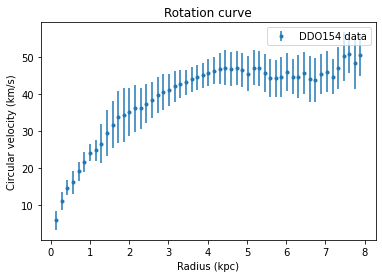

In [41]:
import numpy as np
import matplotlib.pyplot as plt




def f(x,y):
  M_tot = 10**y
  a = 10**x

  M_tot_mean = np.mean(M_tot)                                         #This code would execute properly if the cde above worked
  M_tot_std = np.std(M_tot)
  a_mean = np.mean(a)
  a_std = np.std(a)


  return np.sqrt((GN/radius) * (M_tot*radius**3 / (radius + a)**3))

  plt.hist(M_tot, a, bins = 100, weights = w, density=True)
  plt.show()
print()


plt.errorbar(radius,mu,yerr=sigma,fmt='.',label='DDO154 data') 
plt.xlabel('Radius (kpc)')
plt.ylabel('Circular velocity (km/s)')
plt.title('Rotation curve')

plt.legend()
plt.show()